In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio

# custom module
from data_processing import preprocess, visualize

In [2]:
# # reload modules after making changes
# import importlib
# importlib.reload(preprocess)
# importlib.reload(visualize)

In [3]:
# set constants
TRAINING_IMAGES_DIR = 'data/images/TRAIN' # directory/path to training images
TEST_IMAGES_DIR = 'data/images/TEST' # directory/path to test images
TRAINING_LABELS_PATH = 'data/labels.csv' # path to training labels csv
IMAGE_HEIGHT = 240 #pixels
IMAGE_WIDTH = 320 #pixels

# dictionaries mapping each label to an integer representation (or vice versa)
REP_TO_LABELS = {0: 'EOSINOPHIL', 1: 'LYMPHOCYTE', 2: 'MONOCYTE', 3: 'NEUTROPHIL'}
LABELS_TO_REP = {'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}

In [4]:
# construct tf.data.Datasets to hold our data:
train_set, val_set = preprocess.load_images_dataset(TRAINING_IMAGES_DIR,
                                                    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                                    batch_size=10,
                                                    validation_split=0.2)

Found 9957 files belonging to 4 classes.
Using 7966 files for training.
Using 1991 files for validation.


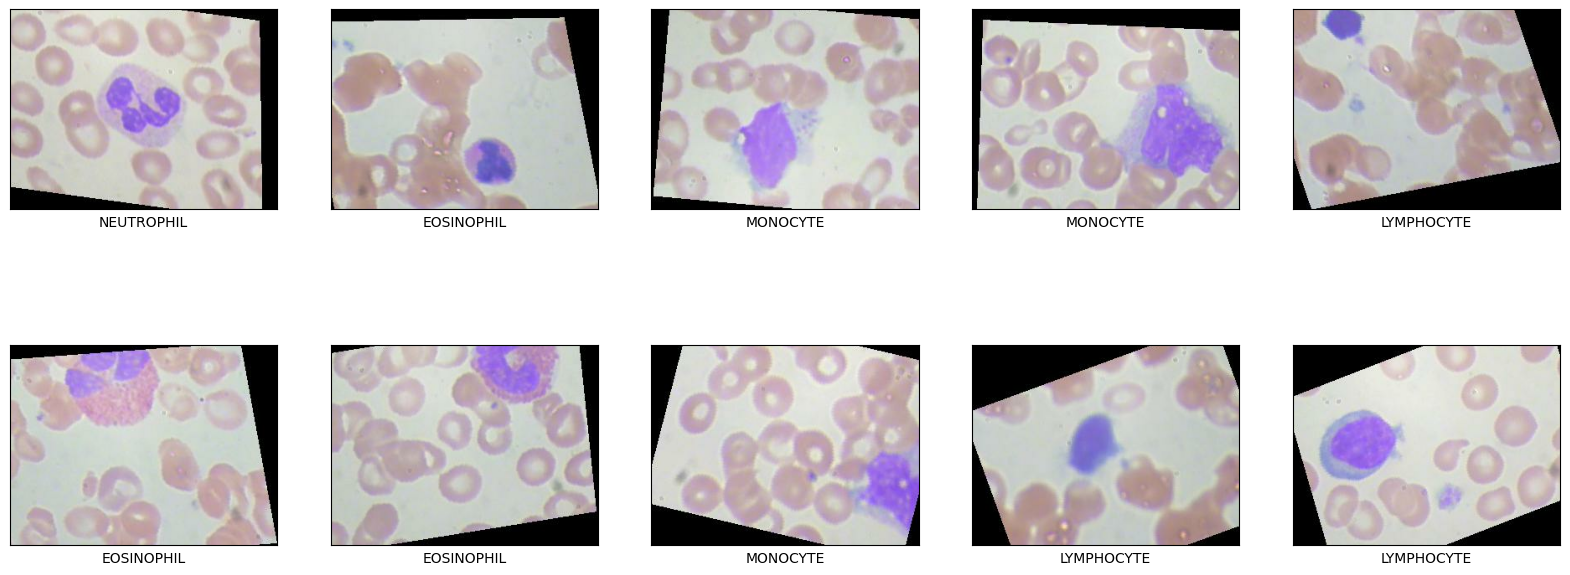

In [5]:
# visualize dataset
visualize.visualize_dataset(train_set, REP_TO_LABELS)

<BarContainer object of 4 artists>

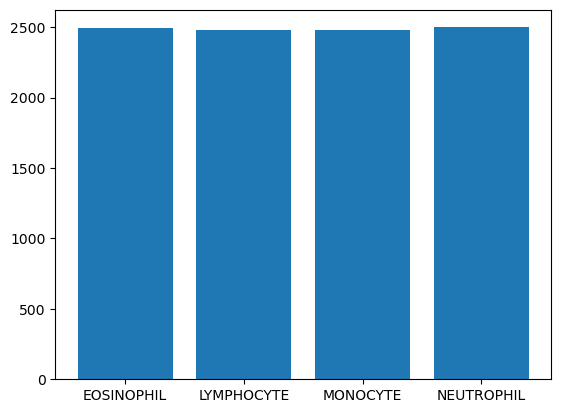

In [6]:
# check distribution of image classes
eosinophil_count = 0
lymphocyte_count = 0
monocyte_count = 0
neutrophil_count = 0

for dirpath, dirnames, filenames in os.walk(TRAINING_IMAGES_DIR):
    top = Path(dirpath).stem
    if top in LABELS_TO_REP.keys():
        if top == "EOSINOPHIL":
            eosinophil_count += len(filenames)
        elif top == "LYMPHOCYTE":
            lymphocyte_count += len(filenames)
        elif top == "MONOCYTE":
            monocyte_count += len(filenames)
        elif top == "NEUTROPHIL":
            neutrophil_count += len(filenames)

plt.bar(LABELS_TO_REP.keys(), [eosinophil_count, lymphocyte_count, monocyte_count, neutrophil_count])

# Model 1: Custom-built Convolutional Neural Network

In [7]:
# import necessary packages
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Add, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

# input layer
inputs = tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

# Standard structure of convolutional layers followed by max pooling layers, repeated two times
x = Conv2D(32, (3,3), activation='relu')(inputs)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation = 'relu')(x)
x = MaxPooling2D((2,2))(x)

# Batch Normalization followed by dropout
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# depthwise convolution (for MobileNet)
x = DepthwiseConv2D((3, 3), activation='relu')(x)

# 1 by 1 convolution layer (for MobileNet)
# followed by max pooling, batch normalization, and dropout
x = Conv2D(64, (1, 1), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# Repeated once more
x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.03))(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.25)(x)

# residual connection for ResNet
residual = Conv2D(64, (1, 1), padding='same')(x)  # added this line
x = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.03))(x)
# the main crux of applying ResNet
x = Add()([x, residual])
# Applying the ReLU activation function to the added layer
x = tf.keras.activations.relu(x)

# Again applying normalization techniques
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# flatten and dense layers
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.03))(x)

# Again applying normalization techniques
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

# Final output layer
outputs = Dense(len(REP_TO_LABELS), activation='softmax')(x)

# create the model
model_built = Model(inputs=inputs, outputs=outputs)

In [8]:
model_built.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 238, 318, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 119, 159, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

# compile the model
model_built.compile(optimizer=keras.optimizers.Adam(1e-4),
                    loss=keras.losses.SparseCategoricalCrossentropy(),
                    metrics=['accuracy'])

# define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# train the model and save its history
history_built = model_built.fit(train_set,
                                epochs=40,
                                validation_data=val_set,
                                callbacks=[early_stopping])

Epoch 1/40
797/797 [==============================] - 29s 33ms/step - loss: 7.2797 - accuracy: 0.4549 - val_loss: 31.5062 - val_accuracy: 0.2421
Epoch 2/40
797/797 [==============================] - 26s 32ms/step - loss: 5.3213 - accuracy: 0.6343 - val_loss: 6.9167 - val_accuracy: 0.3913
Epoch 3/40
797/797 [==============================] - 26s 32ms/step - loss: 3.9539 - accuracy: 0.7206 - val_loss: 4.2540 - val_accuracy: 0.4847
Epoch 4/40
797/797 [==============================] - 26s 33ms/step - loss: 2.9460 - accuracy: 0.7853 - val_loss: 3.8678 - val_accuracy: 0.4058
Epoch 5/40
797/797 [==============================] - 26s 33ms/step - loss: 2.2112 - accuracy: 0.8332 - val_loss: 2.1487 - val_accuracy: 0.7710
Epoch 6/40
797/797 [==============================] - 26s 33ms/step - loss: 1.6709 - accuracy: 0.8638 - val_loss: 3.2267 - val_accuracy: 0.4902
Epoch 7/40
797/797 [==============================] - 26s 33ms/step - loss: 1.2993 - accuracy: 0.8785 - val_loss: 1.9659 - val_accuracy

In the above model ```model_built```, we have implimented ResNet, Batch Normalization, Dropout, and MobileNet, the last of which uses $1 \times 1$ convolution and Depthwise convolution. We first chose to have convolutional layers followed by max pooling layers, repeated two times, with the number of filters increasing from $32$ to $64$ as it's part of a standard convolutional neural network technique. We first thought of having 3 repeats, with the number of filters increasing from $32$ to $64$ and then to $128$, but doing so made our computer crash, so we had to simplify our model. We chose the number of filters to increase from $32$ to $64$ since we wanted the model to capture more complex features as the depth increased.

Batch Normalization is normalizing the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation. It helps to standardize the inputs to each layer and this helps to combat the internal covariate shift problem, leading to faster training and reduces the sensitivity to the initial starting weights.

Dropout is a regularization technique used in neural networks to prevent overfitting. During training, dropout randomly “drops out” (i.e., sets to zero) a fraction of the output features of the layer at each update. This fraction is determined by the dropout rate specified as parameter. In effect, having a dropout layer creates a version of the neural network that is missing some neurons, and this version is used for training. Since the neuraons that are dropped out change during traning, our final training model will be less reliant on any single neuron, thus making our network less likely to overfit.

We chose then to impliment the MobileNet, since we wanted to impliment this structure that we have not encountered in class, and since one of the advantages of using MobileNet is that it uses fewer computational resources.

We now describe how MobileNet works in detail. It consists of two key components, $1 \times 1$ convolutions and depthwise convolutions. A $1 \times 1$ convolution is a regular convolutional layer with a filter size of $1 \times 1$. It's used to reduce the dimensionality in the filter space, allowing us to perform dimensionality reduction. A deptwise convolution is a convolutional layer that applies a single filter to each input channel, unlike a regular convolutional layer that applies a filter that spans across all input channels. Depthwise convolutions are computationally efficient as they can reduce the number of parameters and computations in our neural network. MobileNet is a structure in which we first apply depthwise convolution and then apply $1 \times 1$ convolution.

We also chose the dropout rates of $0.25$ because we found that using $0.2$ led to overfitting, and we saught to mitigate overfitting by increasing the dropout rates as we thought that it could result in our model learning more generalized features of our data.

We chose to impliment ResNet at later stages of our model because our model had many structures and we thought that ResNet could have great impact on mitigating the exploding/vanishing gradient problem if it was implimented at later layers of our model rather than earlier layers.

As for our fully connected layer after the convolutional layers, we were initially thinking about having one fully connected layer with 512 units, but that seemed to take our computer a lot of time to train. We then experimented with two fully connected layers with $128$ and $256$ units respectively, but that choice still made our model take a lot of time to train and our model still was overfitting. We thus chose for a simpler structure of having only one fully connected layer with 256 units.
Since our model was still overfitting, we chose then to apply the L2 regulariation technique to further mitigate the impact of overfitting. According to ChatGPT, I learned that "in general, applying regularization to the later layers can often be more effective at reducing overfitting. This is because the later layers in the network are where the more abstract and complex features are learned. These are the features that are more likely to fit to the noise in the training data, leading to overfitting." Although ChatGPT warned us that this is "not a hard and fast rule," we took its explanation into consideration and chose to apply several L2 regularization at later stages of our model architecture.

Because our model was running way too slowly, we decided to impliment a simpler version of our model, simplifying or removing certain layers and using smaller number of units for many layers.

In [10]:
# input layer
inputs1 = tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

# Standard structure of convolutional layers followed by max pooling layers, repeated two times
x1 = Conv2D(32, (3,3), activation='relu')(inputs1)
x1 = MaxPooling2D((2,2))(x1)

# Batch Normalization followed by dropout
x1 = BatchNormalization()(x1)
x1 = Dropout(0.25)(x1)

# depthwise convolution (for MobileNet)
x1 = DepthwiseConv2D((3, 3), activation='relu')(x1)

# 1 by 1 convolution layer (for MobileNet)
# followed by max pooling, batch normalization, and dropout
x1 = Conv2D(32, (1, 1), activation='relu')(x1)
x1 = MaxPooling2D((2, 2))(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.25)(x1)

# residual connection for ResNet
residual = Conv2D(32, (1, 1), padding='same')(x1)
x1 = Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.03))(x1)
# the main crux of applying ResNet
x1 = Add()([x1, residual])
# Applying the ReLU activation function to the added layer
x1 = tf.keras.activations.relu(x1)

# flatten and dense layers
x1 = GlobalAveragePooling2D()(x1)
x1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.03))(x1)

# Again applying normalization techniques
x1 = BatchNormalization()(x1)
x1 = Dropout(0.25)(x1)

# Final output layer
outputs1 = Dense(len(REP_TO_LABELS), activation='softmax')(x1)

# create the model
model_built1 = Model(inputs=inputs1, outputs=outputs1)

model_built1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 238, 318, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 119, 159, 32  0          ['conv2d_6[0][0]']               
                                )                                                           

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# compile the model
model_built1.compile(optimizer=keras.optimizers.Adam(1e-4),
                     loss=keras.losses.SparseCategoricalCrossentropy(),
                     metrics=['accuracy'])

# define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# train the model and save its history
history_built1 = model_built1.fit(train_set,
                                  epochs=40,
                                  validation_data=val_set,
                                  callbacks=[early_stopping])

Epoch 1/40
797/797 [==============================] - 26s 31ms/step - loss: 3.1022 - accuracy: 0.4549 - val_loss: 3.1439 - val_accuracy: 0.4184
Epoch 2/40
797/797 [==============================] - 24s 30ms/step - loss: 2.3396 - accuracy: 0.6097 - val_loss: 4.8779 - val_accuracy: 0.4028
Epoch 3/40
797/797 [==============================] - 24s 30ms/step - loss: 1.8982 - accuracy: 0.6632 - val_loss: 2.0848 - val_accuracy: 0.5585
Epoch 4/40
797/797 [==============================] - 24s 30ms/step - loss: 1.5999 - accuracy: 0.7004 - val_loss: 2.0163 - val_accuracy: 0.5972
Epoch 5/40
797/797 [==============================] - 24s 30ms/step - loss: 1.3789 - accuracy: 0.7307 - val_loss: 3.2073 - val_accuracy: 0.3998
Epoch 6/40
797/797 [==============================] - 24s 31ms/step - loss: 1.1967 - accuracy: 0.7656 - val_loss: 2.4542 - val_accuracy: 0.4249
Epoch 7/40
797/797 [==============================] - 25s 31ms/step - loss: 1.0937 - accuracy: 0.7717 - val_loss: 2.6285 - val_accuracy:

Now, we shall graph the training and validation accuracy of our model ```model_built```:

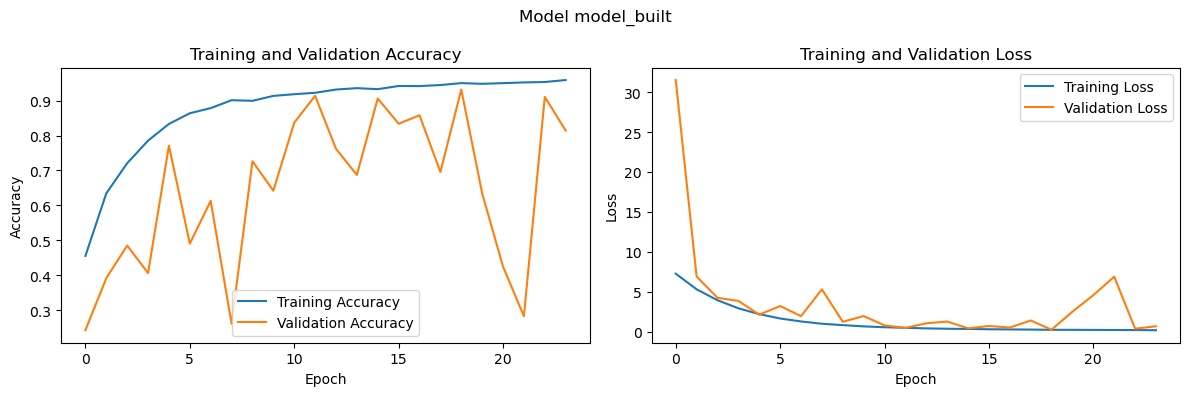

In [12]:
# plot for model_built
visualize.visualize_history(history_built, model_name="model_built")

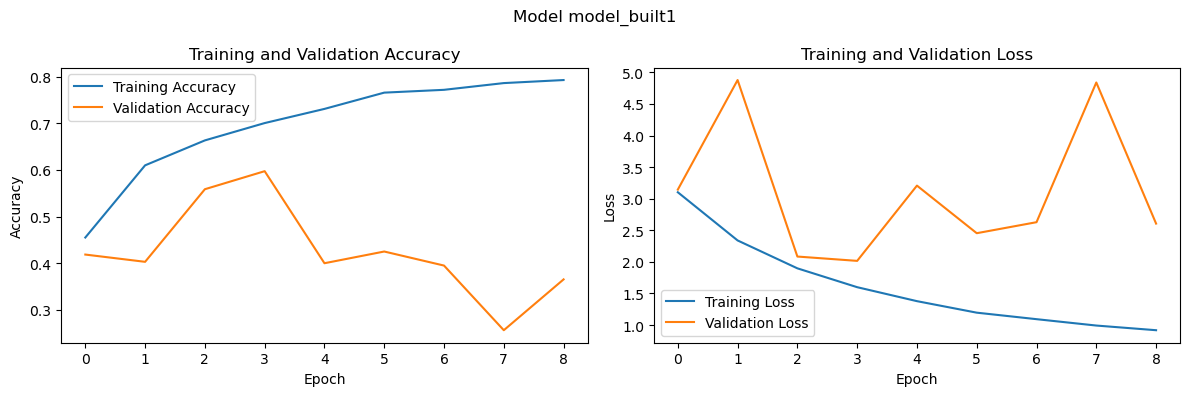

In [13]:
# plot for model_built1
visualize.visualize_history(history_built1, model_name="model_built1")

Now, we can see how our model ```model_built``` performs on the simple test dataset.

In [14]:
# load test set
test_set = preprocess.load_images_dataset(TEST_IMAGES_DIR,
                                          target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                          batch_size=1)

# evaluate the model on the test set
test_loss, test_accuracy = model_built.evaluate(test_set)
test_loss1, test_accuracy1 = model_built1.evaluate(test_set)

print("First model")
print(f'Test accuracy: {test_accuracy}')
print(f'Test loss: {test_loss}')
print("")

print("Second model")
print(f'Test accuracy: {test_accuracy1}')
print(f'Test loss: {test_loss1}')

Found 2487 files belonging to 4 classes.
2487/2487 [==============================] - 8s 3ms/step - loss: 1.9484 - accuracy: 0.6305
First model
Test accuracy: 0.7792521119117737
Test loss: 0.7930136322975159

Second model
Test accuracy: 0.6304785013198853
Test loss: 1.9483598470687866


We'll now pick ten datapoints from our simple test dataset and display the true and predicted labels.

In [15]:
# take 10 batches (10 images from test_set)
test_batch = test_set.take(10)
test_images_list = []
test_labels_list = []
for image, label in test_batch:
    test_images_list.append(image)
    test_labels_list.append(label)
# stack images
test_images = tf.concat(test_images_list, axis=0)
# convert to numpy
test_labels = [label.numpy() for label in test_labels_list]
test_labels = np.stack(test_labels).reshape(10,)

1/1 [==============================] - 0s 189ms/step


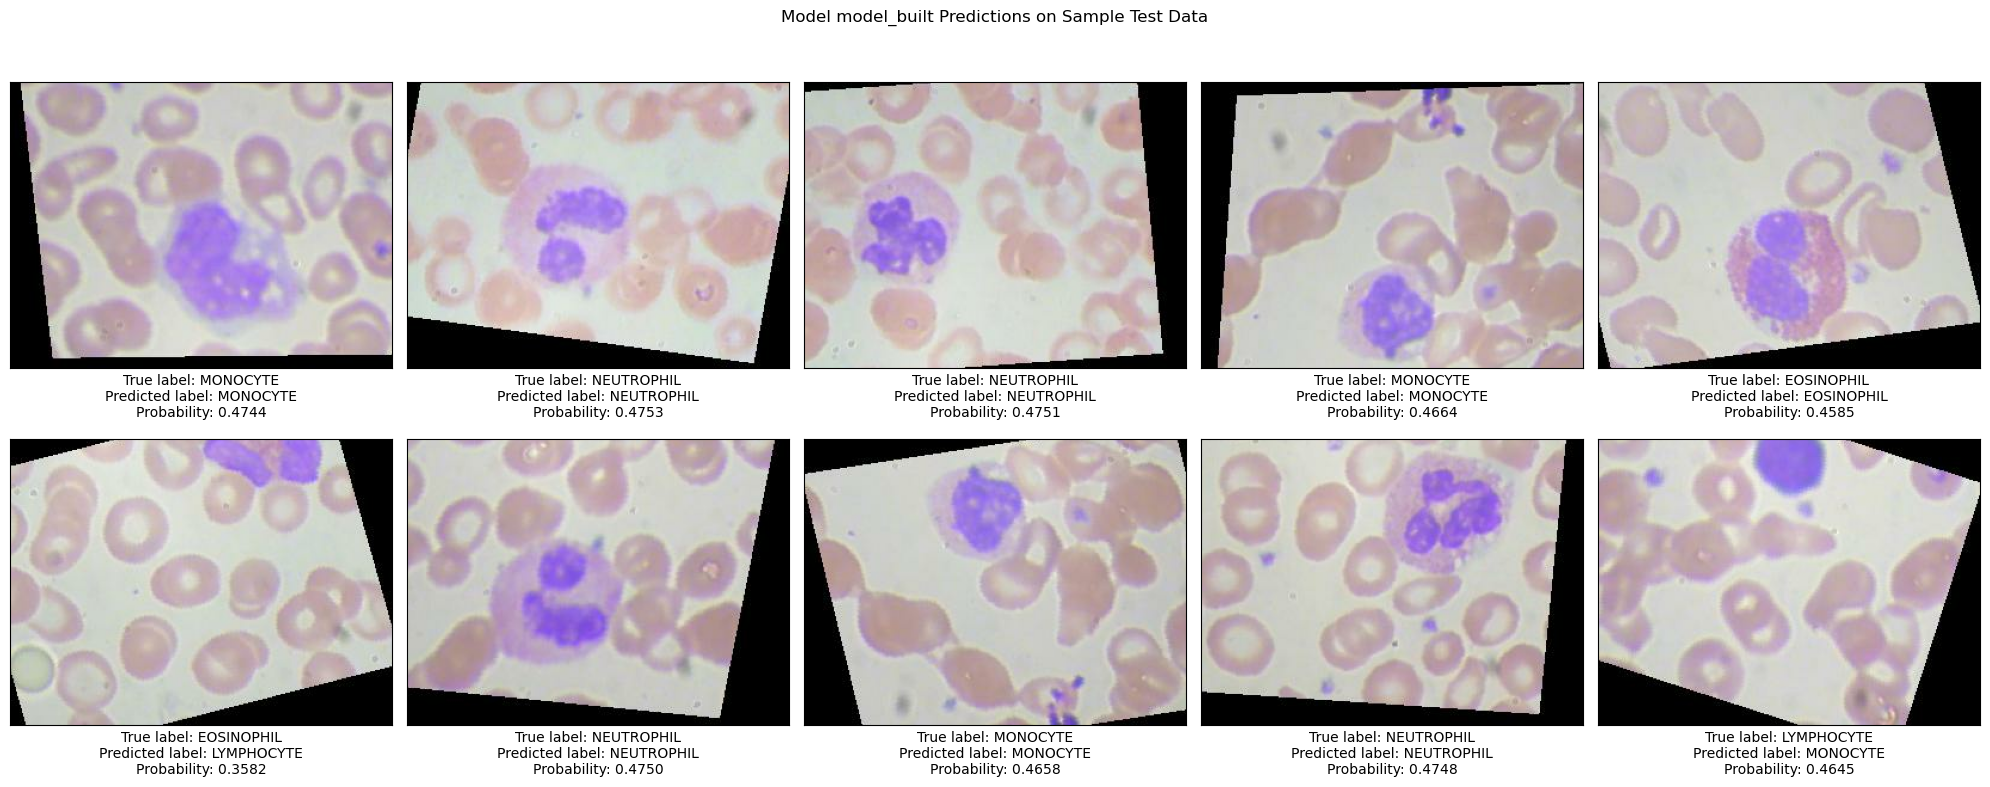

In [16]:
# show images, their true labels, their predicted labels, and the probability
visualize.visualize_predictions(model_built, REP_TO_LABELS, test_images=test_images, test_labels=test_labels, model_name="model_built")

1/1 [==============================] - 0s 128ms/step


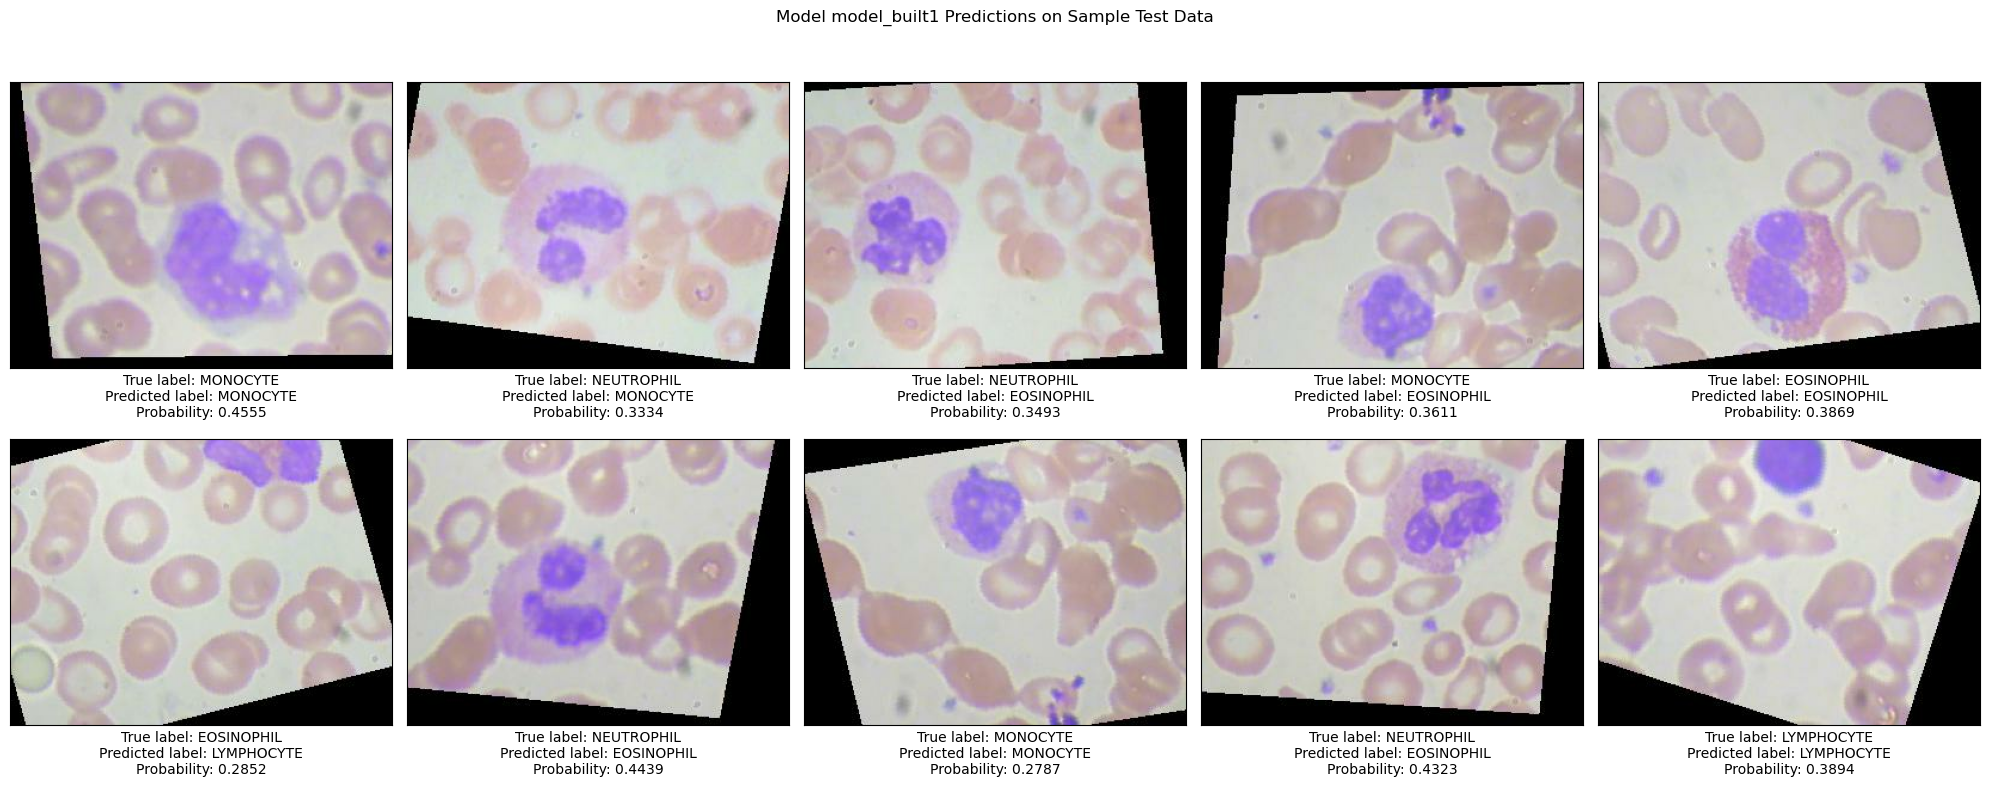

In [17]:
visualize.visualize_predictions(model_built1, REP_TO_LABELS, test_images=test_images, test_labels=test_labels, model_name="model_built1")

              precision    recall  f1-score   support

  EOSINOPHIL       0.90      0.78      0.83       623
  LYMPHOCYTE       0.80      0.50      0.62       620
    MONOCYTE       0.65      1.00      0.79       620
  NEUTROPHIL       0.87      0.84      0.85       624

    accuracy                           0.78      2487
   macro avg       0.80      0.78      0.77      2487
weighted avg       0.80      0.78      0.77      2487



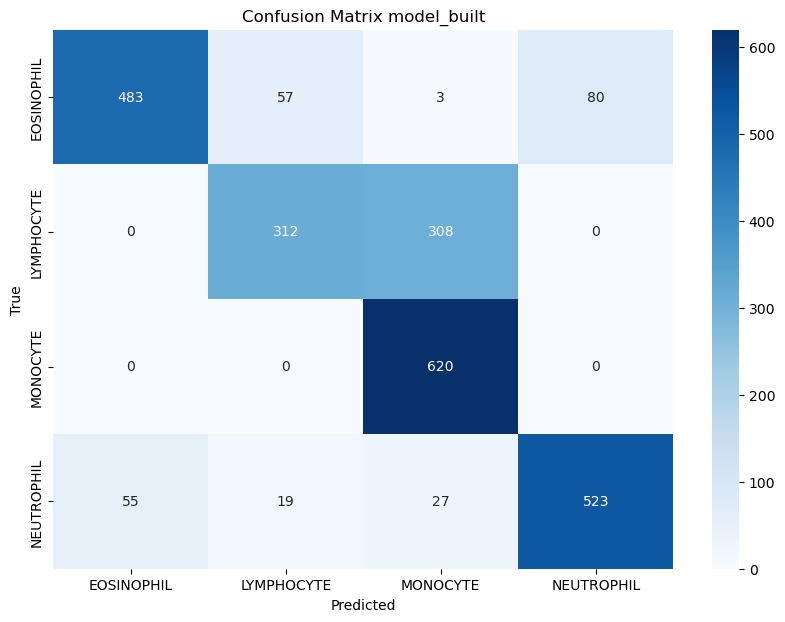

In [18]:
# show confusion matrices
visualize.visualize_conf_matrix(model_built, test_set, REP_TO_LABELS, model_name="model_built")

              precision    recall  f1-score   support

  EOSINOPHIL       0.48      0.76      0.59       623
  LYMPHOCYTE       0.75      0.93      0.83       620
    MONOCYTE       0.71      0.80      0.75       620
  NEUTROPHIL       1.00      0.03      0.06       624

    accuracy                           0.63      2487
   macro avg       0.73      0.63      0.56      2487
weighted avg       0.73      0.63      0.56      2487



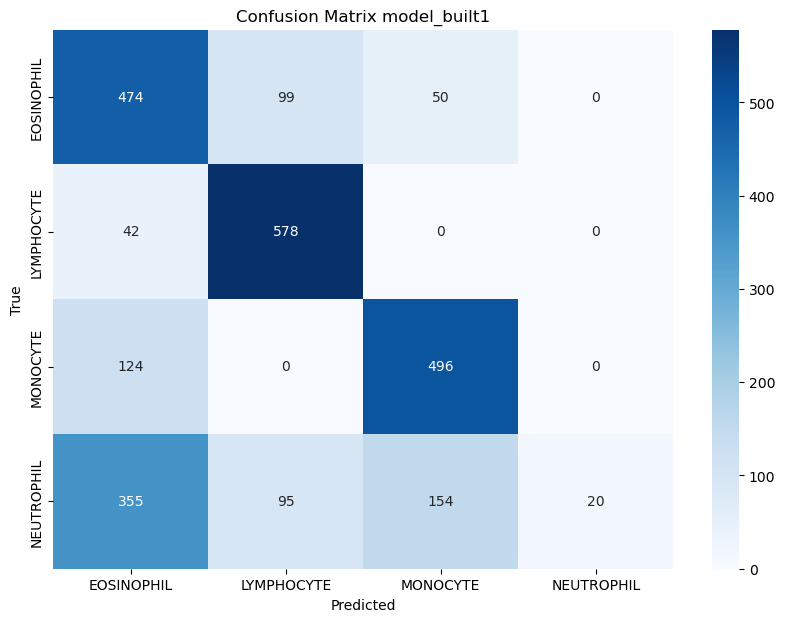

In [19]:
visualize.visualize_conf_matrix(model_built1, test_set, REP_TO_LABELS, model_name="model_built1")